# Comparing Dimensionality Reduction Models to Infer Ancestry in American Admixed Individuals

### Final Project for CSE284
Last Updated: 5/26/2020 by Alyssa Holman

## 1. Import Packages

In [9]:
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import collections
import gzip
from bokeh.palettes import Category20b
from collections import defaultdict
import bokeh
import time
import pandas as pd
from ipywidgets import interact
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file
import itertools
import sklearn
from sklearn import decomposition
import sklearn as sk
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS
import matplotlib.patches as mpatches
from bokeh.palettes import Greys
from bokeh.palettes import Oranges
from bokeh.palettes import Blues
from bokeh.palettes import Purples
from bokeh.palettes import Greens

## 2. Filter out SNPs with MAF <1% and with more than 2 alleles from Chromosome 16 from the 1000 Genomes Project

In [4]:
%%bash
bcftools query -e'AF<0.01' -e'AF>0.99' -f "[%GT\t]\n" ~/Final/ps2_pca.genotypes.vcf.gz | \
  sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g' | \
  grep -v "|" \
  > ~/Final/ps2_pca.genotypes.tab
  
# Extract sample IDs
bcftools query -l ~/Final/ps2_pca.genotypes.vcf.gz > ~/Final/pca.samples.txt

## 3. Principal Component Analysis

### 3.1 Compute Principal Components

In [ ]:
# Ran PC computation locally
import numpy as np
from sklearn.decomposition import PCA
data = np.loadtxt('/Users/Alyssa/Desktop/ps2_pca.genotypes.tab')
data_transpose = data.transpose()
pca_full = PCA().fit(data_transpose)
pca_full.components_.shape

# Calculate the PCs manually. We want a subset of k PCs
k = 30
comps = pca_full.components_[:k,:]

# Mean-center the SNP data and then transform it (projecting to k dimensions)
projections_to_PCs = np.dot((data_transpose - pca_full.mean_), comps.T)
np.savetxt('/Users/Alyssa/Desktop/pca_1000g_100', projections_to_PCs)

In [2]:
# Load variables into datahub
data = np.loadtxt('/home/arholman/final/tscc/cse_final_proj.genotypes.tab')
data_transpose = data.transpose()
projections_to_PCs = np.loadtxt('/home/arholman/final/tscc/pca_1000g_100')

### 3.2 Generate PCA plot displaying main populations by continent with legend

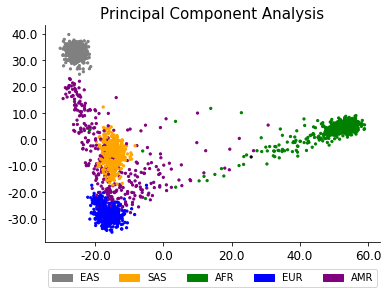

In [31]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Make populations have certain colors
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=projections_to_PCs[:,0]
pc2=projections_to_PCs[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Principal Component Analysis", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)

plt.show()

### 3.3 Generate PCA plot displaying admixed individuals of interest and ancestral counterparts by continent with legend

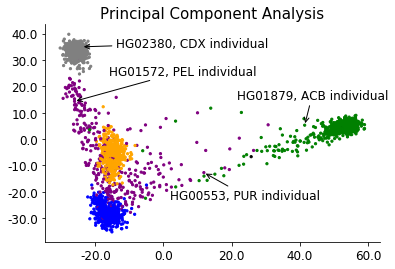

In [93]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=projections_to_PCs[:,0]
pc2=projections_to_PCs[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Principal Component Analysis", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# Label individuals of interest
plt.annotate('HG01572, PEL individual', projections_to_PCs[samples.index('HG01572'),0:2], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(projections_to_PCs[samples.index('HG01572'),0:2][0]+10, 
                    projections_to_PCs[samples.index('HG01572'),0:2][1]+10))
plt.annotate('HG02380, CDX individual', projections_to_PCs[samples.index('HG02380'),0:2], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(projections_to_PCs[samples.index('HG02380'),0:2][0]+10, 
                    projections_to_PCs[samples.index('HG02380'),0:2][1]))
plt.annotate('HG00553, PUR individual', projections_to_PCs[samples.index('HG00553'),0:2], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(projections_to_PCs[samples.index('HG00553'),0:2][0]-10, 
                    projections_to_PCs[samples.index('HG00553'),0:2][1]-10))
plt.annotate('HG01879, ACB individual', projections_to_PCs[samples.index('HG01879'),0:2], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(projections_to_PCs[samples.index('HG01879'),0:2][0]-20, 
                    projections_to_PCs[samples.index('HG01879'),0:2][1]+10))
plt.show()

### 3.4 Generate PCA plot displaying all subpopulations with legend

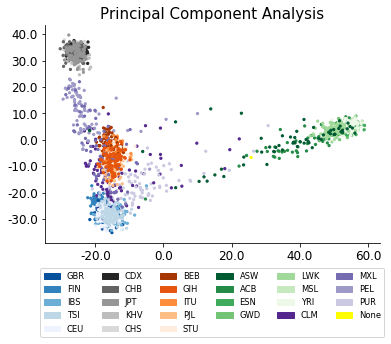

In [32]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

pop_to_color = {'CDX': Greys[6][0], 'CHB': Greys[6][1], 'JPT': Greys[6][2], 'KHV':Greys[6][3], 'CHS':Greys[6][4],
                'BEB': Oranges[5][0], 'GIH': Oranges[5][1], 'ITU': Oranges[5][2], 'PJL': Oranges[5][3], 'STU':Oranges[5][4],
                'ASW':Greens[7][0], 'ACB':Greens[7][1], 'ESN':Greens[7][2], 'GWD':Greens[7][3], 'LWK':Greens[7][4], 'MSL':Greens[7][5], 'YRI':Greens[7][6],
                'GBR':Blues[5][0], 'FIN':Blues[5][1], 'IBS':Blues[5][2], 'TSI':Blues[5][3], 'CEU':Blues[5][4], 
                'CLM':Purples[5][0], 'MXL':Purples[5][1], 'PEL':Purples[5][2], 'PUR':Purples[5][3], "None": "yellow"}
# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=projections_to_PCs[:,0]
pc2=projections_to_PCs[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Principal Component Analysis", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# to annotate plot with each color
list_pop = list(sample_to_pop.items())
pop_pop = []
id_pop = []
color_pop = []
for i in range(len(list_pop)):
    if list_pop[i][1] not in pop_pop: 
        pop_pop.append(list_pop[i][1])
        id_pop.append(list_pop[i][0])

pops = []
for i in range(len(pop_pop)):
    pops.append(mpatches.Patch(color=pop_to_color[pop_pop[i]], label=pop_pop[i]))

# add none
none = mpatches.Patch(color="yellow", label="None")
    
# Put a legend below current axis
ax.legend(handles=[pops[0], pops[1],pops[6], pops[24], pops[17], 
                   pops[4], pops[19], pops[20], pops[9], pops[2],
                   pops[13], pops[25], pops[16], pops[8], pops[15], 
                   pops[22], pops[10], pops[12], pops[11], pops[21], pops[14], pops[18],
                   pops[5], pops[23], pops[7], pops[3], none], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='small', ncol=6)
plt.show()

## 4. Compute MDS for top 30 PCs and raw data

In [203]:
# MDS calculations
mds_raw = MDS().fit_transform(data_transpose)
mds_pc30 = MDS().fit_transform(projections_to_PCs)

In [204]:
# save
np.savetxt('/home/arholman/cse_final_proj/mds_raw_1000g_100', mds_raw)
np.savetxt('/home/arholman/cse_final_proj/mds_30PC_1000g_100', mds_pc30)

In [3]:
# pull into datahub
mds_raw = np.loadtxt('/home/arholman/final/tscc/mds_raw_1000g_100')
mds_pc30 = np.loadtxt('/home/arholman/final/tscc/mds_30PC_1000g_100')

### 4.1 Generate MDS plot for top 30 PCs displaying main populations by continent with legend

Populating the interactive namespace from numpy and matplotlib


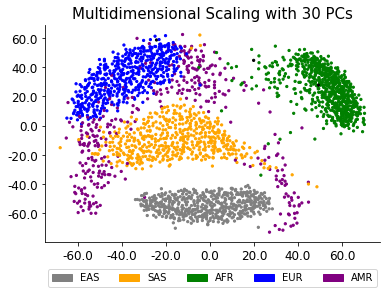

In [16]:
%pylab inline

# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=mds_pc30[:,0]
pc2=mds_pc30[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Multidimensional Scaling with 30 PCs", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)
plt.show()

### 4.2 Find individuals of interest within MDS plot

Based on the plot above, it looks a few AMR individuals cluster near the EAS group in the range of x = 20:40 and y = -60:-80. Below, we will pull these individuals and see what populations they are from. 

In [85]:
mat = np.zeros((1,2))
val = []

# get all y = -60:-80 and x = 20:40 values
for i in range(len(mds_pc30)):
    if (mds_pc30[i][0] > 20) and (mds_pc30[i][0] < 40):
        mat = np.vstack((mat,np.array([mds_pc30[i][0], mds_pc30[i][1]])))
        val.append(i)
first = mat[1:,:]

val2 = []
mat2 = np.zeros((1,2))
for i in range(len(first)):
    if (first[i][1] > -80) and (first[i][1] < -60):
        mat2 = np.vstack((mat2,np.array([first[i][0], first[i][1]])))
        val2.append(val[i])
final = mat2[1:,:]

# to find the ID of interest, pull ID names and population IDs
id_of_interest = []
for i in val2:
    id_of_interest.append(list(sample_to_pop.items())[i])

# if necessary, sort out certain populations
# in this case, not necessary
filt_pop = []
filt_id = []
filt_id2 = []
filt_pop2 = []
for i in range(len(id_of_interest)):
    if id_of_interest[i][1] != 'n': 
        filt_id.append(id_of_interest[i][0])
        filt_pop.append(id_of_interest[i][1])

for i in range(len(filt_pop)):
    if filt_pop[i] != 'm': 
        filt_id2.append(filt_id[i])
        filt_pop2.append(filt_pop[i])

print(filt_id2)
print(filt_pop2)

['HG01572', 'HG01926', 'HG01938', 'HG01954', 'HG01974', 'HG01982', 'HG02147', 'HG02165', 'HG02265', 'HG02271', 'HG02291', 'HG02380', 'HG02386', 'NA19732', 'NA19762']
['PEL', 'PEL', 'PEL', 'PEL', 'PEL', 'PEL', 'PEL', 'CDX', 'PEL', 'PEL', 'PEL', 'CDX', 'CDX', 'MXL', 'MXL']


### 4.3 Generate MDS plot for individuals of interest (zoomed in plot)

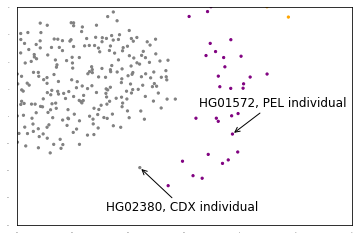

In [107]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=mds_pc30[:,0]
pc2=mds_pc30[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)

# formatting
ax.set_xticklabels(ax.get_xticks(), size=0)
ax.set_yticklabels(ax.get_yticks(), size=0)
ax.tick_params(axis='x',which='both', bottom=False)
ax.tick_params(axis='y',which='both', left=False)
plt.xlim([0, 60])
plt.ylim([-80, -40])

# labeling
plt.annotate('HG01572, PEL individual', mds_pc30[samples.index('HG01572'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(mds_pc30[samples.index('HG01572'),:][0]-6, 
                    mds_pc30[samples.index('HG01572'),:][1]+5))
plt.annotate('HG02380, CDX individual', mds_pc30[samples.index('HG02380'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(mds_pc30[samples.index('HG02380'),:][0]-6, 
                    mds_pc30[samples.index('HG02380'),:][1]-8))

plt.show()

### 4.4 Generate MDS plot for individuals of interest (Full Plot)

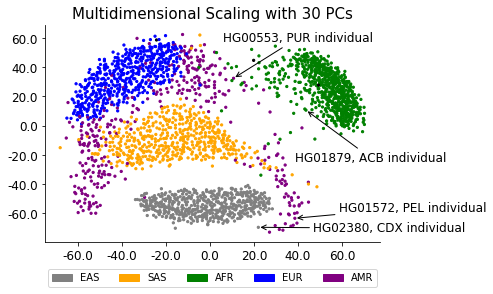

In [120]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=mds_pc30[:,0]
pc2=mds_pc30[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)

# formating
ax.set_title("Multidimensional Scaling with 30 PCs", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)

# labeling
plt.annotate('HG01572, PEL individual', mds_pc30[samples.index('HG01572'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(mds_pc30[samples.index('HG01572'),:][0]+20, 
                    mds_pc30[samples.index('HG01572'),:][1]+5))
plt.annotate('HG02380, CDX individual', mds_pc30[samples.index('HG02380'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(mds_pc30[samples.index('HG02380'),:][0]+25, 
                    mds_pc30[samples.index('HG02380'),:][1]-3))
plt.annotate('HG00553, PUR individual', mds_pc30[samples.index('HG00553'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(mds_pc30[samples.index('HG00553'),:][0]-5, 
                    mds_pc30[samples.index('HG00553'),:][1]+25))
plt.annotate('HG01879, ACB individual', mds_pc30[samples.index('HG01879'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(mds_pc30[samples.index('HG01879'),:][0]-5, 
                    mds_pc30[samples.index('HG01879'),:][1]-35))


plt.show()

### 4.5 Generate MDS plot for top 30 PCs displaying all subpopulations with legend

Populating the interactive namespace from numpy and matplotlib


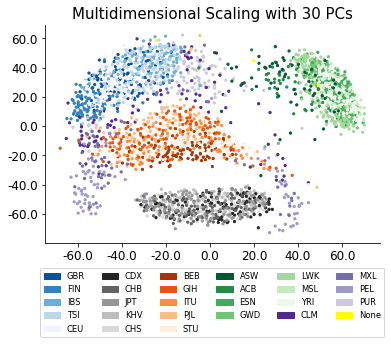

In [34]:
%pylab inline


# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': Greys[6][0], 'CHB': Greys[6][1], 'JPT': Greys[6][2], 'KHV':Greys[6][3], 'CHS':Greys[6][4],
                'BEB': Oranges[5][0], 'GIH': Oranges[5][1], 'ITU': Oranges[5][2], 'PJL': Oranges[5][3], 'STU':Oranges[5][4],
                'ASW':Greens[7][0], 'ACB':Greens[7][1], 'ESN':Greens[7][2], 'GWD':Greens[7][3], 'LWK':Greens[7][4], 'MSL':Greens[7][5], 'YRI':Greens[7][6],
                'GBR':Blues[5][0], 'FIN':Blues[5][1], 'IBS':Blues[5][2], 'TSI':Blues[5][3], 'CEU':Blues[5][4], 
                'CLM':Purples[5][0], 'MXL':Purples[5][1], 'PEL':Purples[5][2], 'PUR':Purples[5][3], "None": "yellow"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=mds_pc30[:,0]
pc2=mds_pc30[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Multidimensional Scaling with 30 PCs", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# to annotate plot with each color
pop_pop = []
id_pop = []
color_pop = []
for i in range(len(list_pop)):
    if list_pop[i][1] not in pop_pop: 
        pop_pop.append(list_pop[i][1])
        id_pop.append(list_pop[i][0])

pops = []
for i in range(len(pop_pop)):
    pops.append(mpatches.Patch(color=pop_to_color[pop_pop[i]], label=pop_pop[i]))

none = mpatches.Patch(color="yellow", label="None")

# Put a legend below current axis
ax.legend(handles=[pops[0], pops[1],pops[6], pops[24], pops[17], 
                   pops[4], pops[19], pops[20], pops[9], pops[2],
                   pops[13], pops[25], pops[16], pops[8], pops[15], 
                   pops[22], pops[10], pops[12], pops[11], pops[21], pops[14], pops[18],
                   pops[5], pops[23], pops[7], pops[3], none], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='small', ncol=6)
plt.show()

### 4.6 Generate MDS plot for raw scores displaying all subpopulations with legend

Populating the interactive namespace from numpy and matplotlib


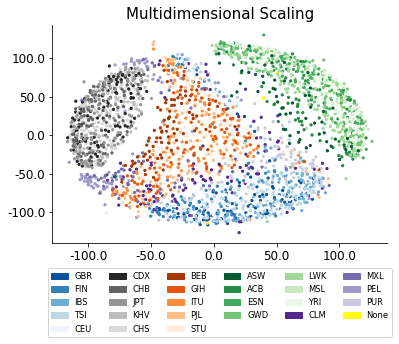

In [35]:
%pylab inline

# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': Greys[6][0], 'CHB': Greys[6][1], 'JPT': Greys[6][2], 'KHV':Greys[6][3], 'CHS':Greys[6][4],
                'BEB': Oranges[5][0], 'GIH': Oranges[5][1], 'ITU': Oranges[5][2], 'PJL': Oranges[5][3], 'STU':Oranges[5][4],
                'ASW':Greens[7][0], 'ACB':Greens[7][1], 'ESN':Greens[7][2], 'GWD':Greens[7][3], 'LWK':Greens[7][4], 'MSL':Greens[7][5], 'YRI':Greens[7][6],
                'GBR':Blues[5][0], 'FIN':Blues[5][1], 'IBS':Blues[5][2], 'TSI':Blues[5][3], 'CEU':Blues[5][4], 
                'CLM':Purples[5][0], 'MXL':Purples[5][1], 'PEL':Purples[5][2], 'PUR':Purples[5][3], "None": "yellow"}


# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=mds_raw[:,0]
pc2=mds_raw[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Multidimensional Scaling", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# to annotate plot with each color
pop_pop = []
id_pop = []
color_pop = []
for i in range(len(list_pop)):
    if list_pop[i][1] not in pop_pop: 
        pop_pop.append(list_pop[i][1])
        id_pop.append(list_pop[i][0])

pops = []
for i in range(len(pop_pop)):
    pops.append(mpatches.Patch(color=pop_to_color[pop_pop[i]], label=pop_pop[i]))

none = mpatches.Patch(color="yellow", label="None")

# Put a legend below current axis
ax.legend(handles=[pops[0], pops[1],pops[6], pops[24], pops[17], 
                   pops[4], pops[19], pops[20], pops[9], pops[2],
                   pops[13], pops[25], pops[16], pops[8], pops[15], 
                   pops[22], pops[10], pops[12], pops[11], pops[21], pops[14], pops[18],
                   pops[5], pops[23], pops[7], pops[3], none], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='small', ncol=6)
plt.show()

### 4.7 Generate MDS plot for raw scores displaying main populations by continent with legend

Populating the interactive namespace from numpy and matplotlib


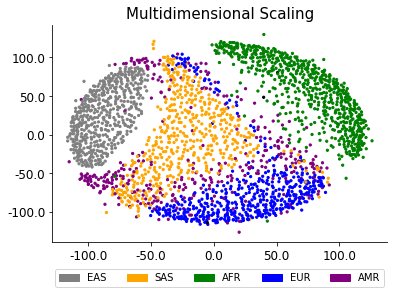

In [36]:
%pylab inline

# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=mds_raw[:,0]
pc2=mds_raw[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("Multidimensional Scaling", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)

plt.show()

## 5. Compute tSNE for top 30 PCs

In [235]:
# compute for 30 PCs
genotype_tsne = sk.manifold.TSNE(n_components=2).fit_transform(projections_to_PCs)

In [236]:
# save tsne
np.savetxt('/home/arholman/cse_final_proj/tsne_1000g_100', genotype_tsne)

In [4]:
# load PCs
genotype_tsne = np.loadtxt('/home/arholman/final/tscc/tsne_1000g_100')

### 5.1 Generate tSNE plot for PCs displaying main populations by continent with legend

Populating the interactive namespace from numpy and matplotlib


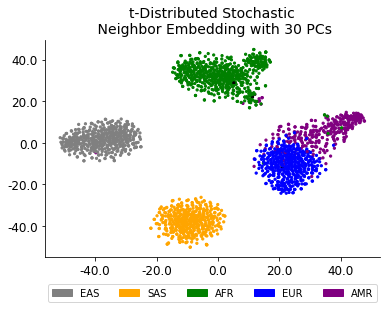

In [121]:
%pylab inline

# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=genotype_tsne[:,0]
pc2=genotype_tsne[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("t-Distributed Stochastic\n Neighbor Embedding with 30 PCs", size=14)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)

plt.show()

### 5.2 Finding individuals of interest within tSNE plot

Based on the plot above, it looks a few AMR individuals cluster near the AFR group in the range of x = 7.5:17.5 and y = 15:25. Below, we will pull these individuals and see what populations they are from. 

In [64]:
mat = np.zeros((1,2))
val = []

# pull x values
for i in range(len(genotype_tsne)):
    if (genotype_tsne[i][0] > 7.5) and (genotype_tsne[i][0] < 17.5):
        mat = np.vstack((mat,np.array([genotype_tsne[i][0], genotype_tsne[i][1]])))
        val.append(i)
first = mat[1:,:]

# pull y values
val2 = []
mat2 = np.zeros((1,2))
for i in range(len(first)):
    if (first[i][1] > 15) and (first[i][1] < 25):
        mat2 = np.vstack((mat2,np.array([first[i][0], first[i][1]])))
        val2.append(val[i])
final = mat2[1:,:]

# pull individuals and population IDs
id_of_interest = []
for i in val2:
    id_of_interest.append(list(sample_to_pop.items())[i])

# if we want, can sort out AFR individuals to pull only AMR individuals
# but we will not do that here
filt_pop = []
filt_id = []
filt_id2 = []
filt_pop2 = []
for i in range(len(id_of_interest)):
    if id_of_interest[i][1] != 'non': 
        filt_id.append(id_of_interest[i][0])
        filt_pop.append(id_of_interest[i][1])

for i in range(len(filt_pop)):
    if filt_pop[i] != 'non': 
        filt_id2.append(filt_id[i])
        filt_pop2.append(filt_pop[i])

print(filt_id2)
print(filt_pop2)

['HG00553', 'HG01077', 'HG01107', 'HG01108', 'HG01241', 'HG01242', 'HG01342', 'HG01462', 'HG01485', 'HG01879', 'HG01958', 'HG01988', 'HG01989', 'HG02108', 'HG02255', 'HG02314', 'HG02317', 'HG02337', 'HG02419', 'HG02420', 'HG02427', 'HG02445', 'HG02477', 'HG02505', 'HG02536', 'HG02555', 'HG02580', 'NA19704', 'NA19713', 'NA19719', 'NA19900', 'NA19901', 'NA19920', 'NA19923', 'NA19984', 'NA20276', 'NA20287', 'NA20289', 'NA20291', 'NA20296', 'NA20342', 'NA20351', 'NA20355', 'NA20357', 'NA20359']
['PUR', 'PUR', 'PUR', 'PUR', 'PUR', 'PUR', 'CLM', 'CLM', 'CLM', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ACB', 'ASW', 'ASW', 'MXL', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW', 'ASW']


### 5.3 Generate tSNE plot for individuals of interest (zoomed in plot)

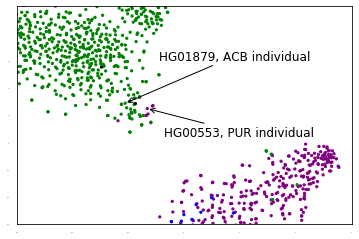

In [117]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=genotype_tsne[:,0]
pc2=genotype_tsne[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)

# formating
ax.set_xticklabels(ax.get_xticks(), size=0)
ax.set_yticklabels(ax.get_yticks(), size=0)
ax.tick_params(axis='x',which='both', bottom=False)
ax.tick_params(axis='y',which='both', left=False)
plt.xlim([-10, 50])
plt.ylim([0, 40])

# labels
plt.annotate('HG00553, PUR individual', genotype_tsne[samples.index('HG00553'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(genotype_tsne[samples.index('HG00553'),:][0]+3, 
                    genotype_tsne[samples.index('HG00553'),:][1]-5))
plt.annotate('HG01879, ACB individual', genotype_tsne[samples.index('HG01879'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(genotype_tsne[samples.index('HG01879'),:][0]+6, 
                    genotype_tsne[samples.index('HG01879'),:][1]+8))

plt.show()


### 5.4 Generate tSNE plot for individuals of interest (Full Plot)

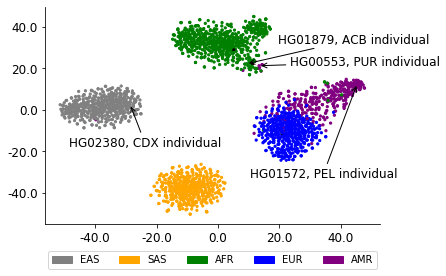

In [122]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=genotype_tsne[:,0]
pc2=genotype_tsne[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)

# formatting
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)


# labeling
plt.annotate('HG01572, PEL individual', genotype_tsne[samples.index('HG01572'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(genotype_tsne[samples.index('HG01572'),:][0]-35, 
                    genotype_tsne[samples.index('HG01572'),:][1]-45))
plt.annotate('HG02380, CDX individual', genotype_tsne[samples.index('HG02380'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(genotype_tsne[samples.index('HG02380'),:][0]-20, 
                    genotype_tsne[samples.index('HG02380'),:][1]-20))
plt.annotate('HG00553, PUR individual', genotype_tsne[samples.index('HG00553'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(genotype_tsne[samples.index('HG00553'),:][0]+10, 
                    genotype_tsne[samples.index('HG00553'),:][1]))
plt.annotate('HG01879, ACB individual', genotype_tsne[samples.index('HG01879'),:], 
             arrowprops=dict(arrowstyle= '->'), size = 12,  
            xytext=(genotype_tsne[samples.index('HG01879'),:][0]+10, 
                    genotype_tsne[samples.index('HG01879'),:][1]+10))

plt.show()

### 5.5 Generate tSNE plot for 30 PCs displaying all subpopulations with legend

Populating the interactive namespace from numpy and matplotlib


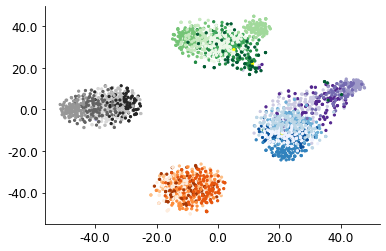

In [14]:
%pylab inline

# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': Greys[6][0], 'CHB': Greys[6][1], 'JPT': Greys[6][2], 'KHV':Greys[6][3], 'CHS':Greys[6][4],
                'BEB': Oranges[5][0], 'GIH': Oranges[5][1], 'ITU': Oranges[5][2], 'PJL': Oranges[5][3], 'STU':Oranges[5][4],
                'ASW':Greens[7][0], 'ACB':Greens[7][1], 'ESN':Greens[7][2], 'GWD':Greens[7][3], 'LWK':Greens[7][4], 'MSL':Greens[7][5], 'YRI':Greens[7][6],
                'GBR':Blues[5][0], 'FIN':Blues[5][1], 'IBS':Blues[5][2], 'TSI':Blues[5][3], 'CEU':Blues[5][4], 
                'CLM':Purples[5][0], 'MXL':Purples[5][1], 'PEL':Purples[5][2], 'PUR':Purples[5][3], "None": "yellow"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=genotype_tsne[:,0]
pc2=genotype_tsne[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# to annotate plot with each color
pop_pop = []
id_pop = []
color_pop = []
for i in range(len(list_pop)):
    if list_pop[i][1] not in pop_pop: 
        pop_pop.append(list_pop[i][1])
        id_pop.append(list_pop[i][0])

pops = []
for i in range(len(pop_pop)):
    pops.append(mpatches.Patch(color=pop_to_color[pop_pop[i]], label=pop_pop[i]))

none = mpatches.Patch(color="yellow", label="None")

# Put a legend below current axis
# ax.legend(handles=[pops[0], pops[1],pops[6], pops[24], pops[17], 
#                    pops[4], pops[19], pops[20], pops[9], pops[2],
#                    pops[13], pops[25], pops[16], pops[8], pops[15], 
#                    pops[22], pops[10], pops[12], pops[11], pops[21], pops[14], pops[18],
#                    pops[5], pops[23], pops[7], pops[3], none], 
#           loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
#           fontsize='small', ncol=6)

plt.show()

### 5.6 Generate tSNE analysis on raw data

In [85]:
# t-SNE projection on non-transformed data
tsne_raw = sk.manifold.TSNE(n_components = 2).fit_transform(data_transpose)

In [95]:
# save data
np.savetxt('/home/arholman/cse_final_proj/tsne_raw_1000g_100', tsne_raw)

In [5]:
# load in data to datahub
tsne_raw = np.loadtxt('/home/arholman/final/tscc/tsne_raw_1000g_100')

### 5.7 Generate tSNE plot for raw scores displaying main populations by continent with legend

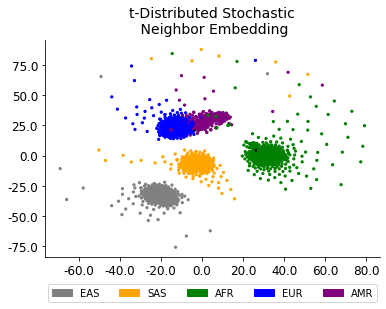

In [123]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': "gray", 'CHB': "gray", 'JPT': "gray", 'KHV':"gray", 'CHS':"gray",
                'BEB':"orange", 'GIH':"orange", 'ITU':"orange", 'PJL':"orange", 'STU':"orange",
                'ASW':"green", 'ACB':"green", 'ESN':"green", 'GWD':"green", 'LWK':"green", 'MSL':"green", 'YRI':"green",
                'GBR':"blue", 'FIN':"blue", 'IBS':"blue", 'TSI':"blue", 'CEU':"blue", 
                'CLM':"purple", 'MXL':"purple", 'PEL':"purple", 'PUR':"purple", "None": "black"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=tsne_raw[:,0]
pc2=tsne_raw[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_title("t-Distributed Stochastic\n Neighbor Embedding", size=14)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# Put a legend below current axis
g_patch = mpatches.Patch(color='gray', label='EAS')
o_patch = mpatches.Patch(color='orange', label='SAS')
gr_patch = mpatches.Patch(color='green', label='AFR')
b_patch = mpatches.Patch(color='blue', label='EUR')
p_patch = mpatches.Patch(color='purple', label='AMR')
ax.legend(handles=[g_patch, o_patch, gr_patch, b_patch, p_patch], 
          loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
          fontsize='medium', ncol=5)

plt.show()

### 5.8 Generate tSNE plot for raw data displaying all subpopulations with legend

Populating the interactive namespace from numpy and matplotlib


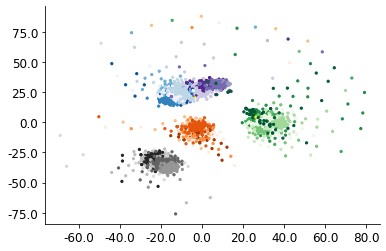

In [11]:
# Load population labels
sample_to_pop = {}
with open("/home/arholman/final/tscc/ps2_reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

# Recommended colors for each population group
pop_to_color = {'CDX': Greys[6][0], 'CHB': Greys[6][1], 'JPT': Greys[6][2], 'KHV':Greys[6][3], 'CHS':Greys[6][4],
                'BEB': Oranges[5][0], 'GIH': Oranges[5][1], 'ITU': Oranges[5][2], 'PJL': Oranges[5][3], 'STU':Oranges[5][4],
                'ASW':Greens[7][0], 'ACB':Greens[7][1], 'ESN':Greens[7][2], 'GWD':Greens[7][3], 'LWK':Greens[7][4], 'MSL':Greens[7][5], 'YRI':Greens[7][6],
                'GBR':Blues[5][0], 'FIN':Blues[5][1], 'IBS':Blues[5][2], 'TSI':Blues[5][3], 'CEU':Blues[5][4], 
                'CLM':Purples[5][0], 'MXL':Purples[5][1], 'PEL':Purples[5][2], 'PUR':Purples[5][3], "None": "yellow"}

# Load samples list and get colors
if not os.path.exists(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt")):
    samples = []
else: samples = [item.strip() for item in open(os.path.join(os.environ["HOME"], "final/tscc/", "pca.samples.txt"), "r").readlines()]
colors = []
for sample in samples:
    pop = sample_to_pop.get(sample, "None")
    color = pop_to_color[pop]
    colors.append(color)

# Load PCs
pc1=tsne_raw[:,0]
pc2=tsne_raw[:,1]

# Make the plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();

# to annotate plot with each color
list_pop = list(sample_to_pop.items())
pop_pop = []
id_pop = []
color_pop = []
for i in range(len(list_pop)):
    if list_pop[i][1] not in pop_pop: 
        pop_pop.append(list_pop[i][1])
        id_pop.append(list_pop[i][0])

pops = []
for i in range(len(pop_pop)):
    pops.append(mpatches.Patch(color=pop_to_color[pop_pop[i]], label=pop_pop[i]))

# add none to legend
none = mpatches.Patch(color="yellow", label="None")
    
# Put a legend below current axis
# ax.legend(handles=[pops[0], pops[1],pops[6], pops[24], pops[17], 
#                    pops[4], pops[19], pops[20], pops[9], pops[2],
#                    pops[13], pops[25], pops[16], pops[8], pops[15], 
#                    pops[22], pops[10], pops[12], pops[11], pops[21], pops[14], pops[18],
#                    pops[5], pops[23], pops[7], pops[3], none], 
#           loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, 
#           fontsize='small', ncol=6)
plt.show()